# Phase 2 – Understanding & Preparation of Data

**Project:** Intelligent Financial Risk Classification for Small Businesses Using Machine Learning

**Objective:** Prepare and clean the dataset for machine learning model training

---


## 1. Setup and Imports


In [16]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Add src to path
sys.path.insert(0, str(Path.cwd()))

# Import project modules
from src.data.load_data import load_polish_bankruptcy_data, create_risk_categories
from src.data.clean_data import handle_missing_values, remove_duplicates, handle_outliers
from src.data.prepare_features import remove_redundant_features, encode_categorical, scale_features
from src.config import (
    RAW_DATA_DIR, PROCESSED_DATA_DIR, SPLITS_DATA_DIR, ARTIFACTS_DIR,
    TRAIN_SIZE, TEST_SIZE, RANDOM_SEED
)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")


✓ Imports successful


## 2. Data Loading

### 2.1 Load Dataset

Load the Polish Companies Bankruptcy Data from UCI Machine Learning Repository.


In [17]:
# Load dataset
df = load_polish_bankruptcy_data(year=5)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (5910, 65)

Columns: 65

First few rows:


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.088238,0.55472,0.01134,1.0205,-66.5200,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.2597,0
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.000000,-0.006202,1.06340,1.2757,0.51535,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.3700,0
2,0.130240,0.22142,0.57751,3.6082,120.0400,0.187640,0.162120,3.05900,1.1415,0.67731,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.6188,0
3,-0.089951,0.88700,0.26927,1.5222,-55.9920,-0.073957,-0.089951,0.12740,1.2754,0.11300,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.9299,0
4,0.048179,0.55041,0.10765,1.2437,-22.9590,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.3622,0


### 2.2 Explore Original Data


Original Bankruptcy Distribution:
class
0    5500
1     410
Name: count, dtype: int64

Percentages:
class
0    93.062606
1     6.937394
Name: proportion, dtype: float64


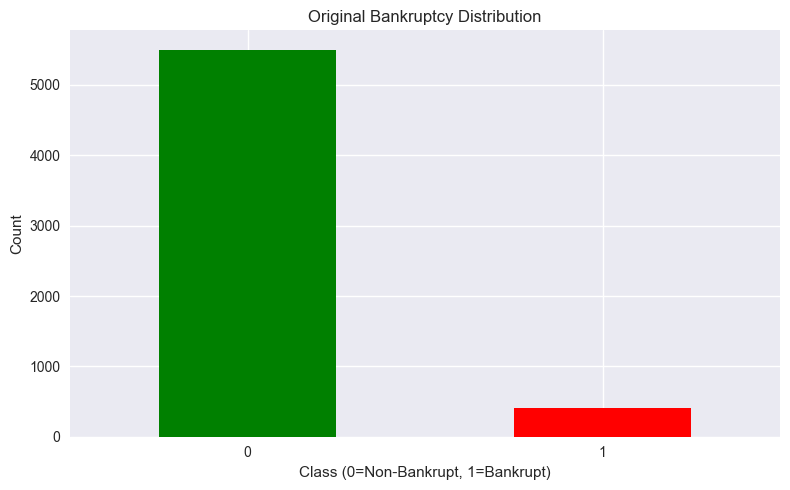

In [18]:
# Check original bankruptcy distribution
print("Original Bankruptcy Distribution:")
print(df['class'].value_counts())
print("\nPercentages:")
print(df['class'].value_counts(normalize=True) * 100)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df['class'].value_counts().plot(kind='bar', ax=ax, color=['green', 'red'])
ax.set_title('Original Bankruptcy Distribution')
ax.set_xlabel('Class (0=Non-Bankrupt, 1=Bankrupt)')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 2.3 Create Risk Categories

Convert binary bankruptcy classification to 3-class risk levels.


Risk Level Distribution:
risk_level
High      1235
Low       3300
Medium    1375
Name: count, dtype: int64

Percentages:
risk_level
High      20.896785
Low       55.837563
Medium    23.265651
Name: proportion, dtype: float64


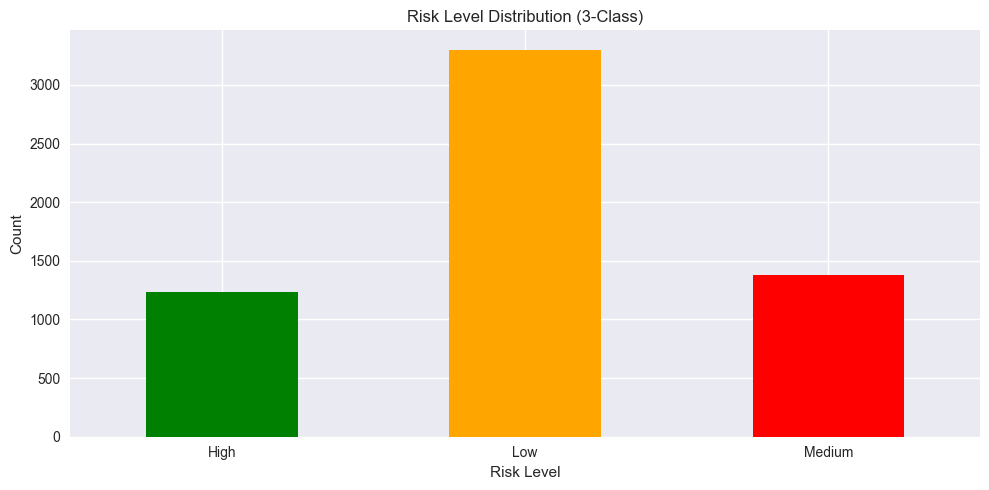

In [19]:
# Create risk categories
df_risk = create_risk_categories(df)

print("Risk Level Distribution:")
print(df_risk['risk_level'].value_counts().sort_index())
print("\nPercentages:")
print(df_risk['risk_level'].value_counts(normalize=True).sort_index() * 100)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
risk_counts = df_risk['risk_level'].value_counts().sort_index()
colors = ['green', 'orange', 'red']
risk_counts.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Risk Level Distribution (3-Class)')
ax.set_xlabel('Risk Level')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 3. Data Quality Analysis

### 3.1 Missing Values Analysis


Total missing values: 4666
Features with missing values: 49

Top 10 features with most missing values:
        Missing Count  Missing %
Attr37           2548  43.113367
Attr27            391   6.615905
Attr45            268   4.534687
Attr60            268   4.534687
Attr24            135   2.284264
Attr64            107   1.810491
Attr53            107   1.810491
Attr28            107   1.810491
Attr54            107   1.810491
Attr21            103   1.742809


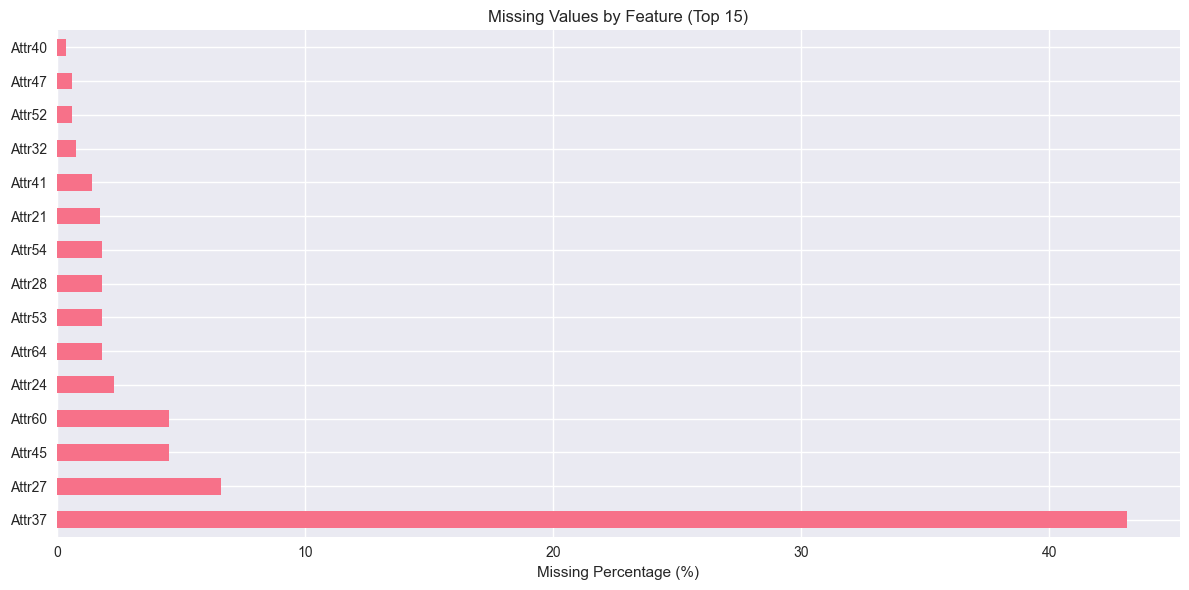

In [20]:
# Separate features and target
X = df_risk.drop(columns=['risk_level', 'class'], errors='ignore')
y = df_risk['risk_level']

# Analyze missing values
missing_analysis = X.isnull().sum()
missing_pct = (missing_analysis / len(X)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_analysis,
    'Missing %': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print(f"Total missing values: {X.isnull().sum().sum()}")
print(f"Features with missing values: {len(missing_df)}")
print("\nTop 10 features with most missing values:")
print(missing_df.head(10))

# Visualize
if len(missing_df) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    missing_df.head(15)['Missing %'].plot(kind='barh', ax=ax)
    ax.set_title('Missing Values by Feature (Top 15)')
    ax.set_xlabel('Missing Percentage (%)')
    plt.tight_layout()
    plt.show()


### 3.2 Handle Missing Values


In [21]:
# Handle missing values
missing_before = X.isnull().sum().sum()
X_clean = handle_missing_values(X)
missing_after = X_clean.isnull().sum().sum()

print(f"Missing values before: {missing_before}")
print(f"Missing values after: {missing_after}")
print(f"✓ Missing values handled: {missing_before - missing_after} values imputed")


Missing values before: 4666
Missing values after: 0
✓ Missing values handled: 4666 values imputed


### 3.3 Duplicate Detection


In [22]:
# Check for duplicates
duplicates = X_clean.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")

if duplicates > 0:
    X_clean = remove_duplicates(X_clean)
    # Also remove corresponding y values
    y_clean = y.iloc[X_clean.index]
    print(f"✓ Removed {duplicates} duplicate rows")
else:
    y_clean = y
    print("✓ No duplicates found")


Duplicate rows found: 60
✓ Removed 60 duplicate rows


### 3.4 Outlier Analysis


In [23]:
# Handle outliers (winsorization)
X_clean = handle_outliers(X_clean, clip_percentiles=True)
print("✓ Outliers clipped at 1st and 99th percentiles")

# Show summary statistics
print("\nSummary statistics (sample of 5 features):")
X_clean.select_dtypes(include=[np.number]).iloc[:, :5].describe()


✓ Outliers clipped at 1st and 99th percentiles

Summary statistics (sample of 5 features):


,Attr1,Attr2,Attr3,Attr4,Attr5
count,5850.000000,5850.000000,5850.000000,5850.000000,5850.000000
mean,0.051848,0.498308,0.213291,2.806215,0.914643
std,0.153267,0.343391,0.332078,3.715502,156.114351
min,-0.579468,0.017743,-1.205131,0.186921,-717.750000
25%,0.004000,0.257345,0.043530,1.093750,-43.699000
50%,0.046670,0.452175,0.219640,1.651700,0.491490
75%,0.117055,0.662092,0.418200,2.918100,48.466750
max,0.536238,2.203200,0.899921,26.324090,693.798600


## 4. Feature Preparation

### 4.1 Remove Redundant Features


In [24]:
# Remove highly correlated features
before_features = X_clean.shape[1]
X_features, features_kept = remove_redundant_features(X_clean)
after_features = X_features.shape[1]

print(f"Features before: {before_features}")
print(f"Features after: {after_features}")
print(f"✓ Removed {before_features - after_features} redundant features (correlation > 0.95)")


Features before: 65
Features after: 53
✓ Removed 12 redundant features (correlation > 0.95)


### 4.2 Encode Categorical Features


In [25]:
# Encode categorical features
X_encoded = encode_categorical(X_features)
print(f"Features after encoding: {X_encoded.shape[1]}")
print(f"✓ Categorical features encoded (if any)")


Features after encoding: 53
✓ Categorical features encoded (if any)


## 5. Data Splitting

### 5.1 Split into Train/Test Sets


Training set: 4094 samples
Test set: 1755 samples

Training distribution:
risk_level
High       859
Low       2285
Medium     950
Name: count, dtype: int64

Test distribution:
risk_level
High      368
Low       979
Medium    408
Name: count, dtype: int64


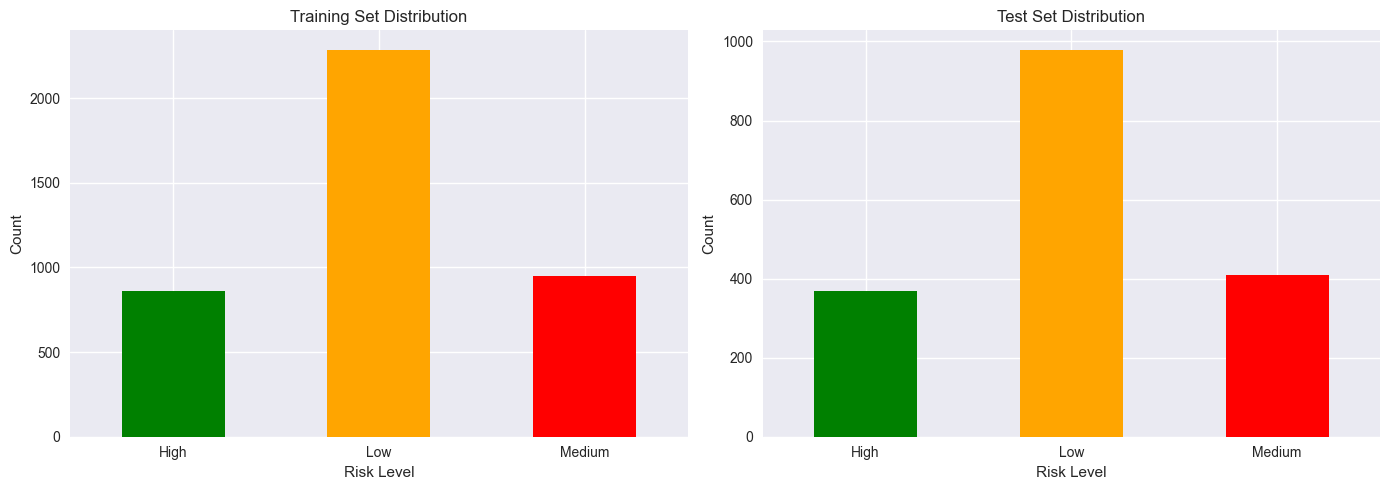

In [26]:
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_clean,
    test_size=TEST_SIZE,
    train_size=TRAIN_SIZE,
    stratify=y_clean,
    random_state=RANDOM_SEED
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest distribution:")
print(y_test.value_counts().sort_index())

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y_train.value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

y_test.value_counts().sort_index().plot(kind='bar', ax=axes[1], color=['green', 'orange', 'red'])
axes[1].set_title('Test Set Distribution')
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


### 5.2 Scale Features


✓ Features scaled using StandardScaler
Training shape: (4094, 53)
Test shape: (1755, 53)


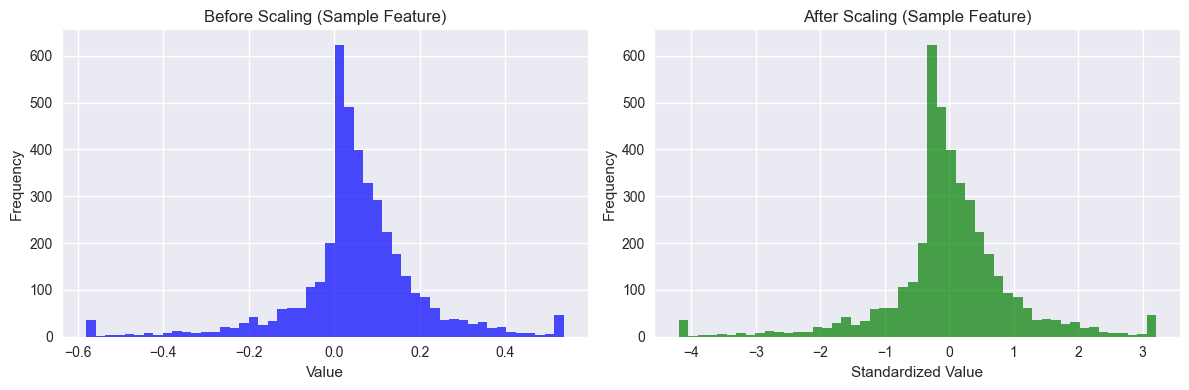

In [27]:
# Scale features
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

print(f"✓ Features scaled using StandardScaler")
print(f"Training shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")

# Show scaling effect (sample feature)
if X_train_scaled.shape[1] > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Before scaling (first feature)
    axes[0].hist(X_train.iloc[:, 0], bins=50, alpha=0.7, color='blue')
    axes[0].set_title('Before Scaling (Sample Feature)')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    
    # After scaling
    axes[1].hist(X_train_scaled[:, 0], bins=50, alpha=0.7, color='green')
    axes[1].set_title('After Scaling (Sample Feature)')
    axes[1].set_xlabel('Standardized Value')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


## 6. Save Processed Data


In [28]:
# Create directories
Path(PROCESSED_DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(SPLITS_DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(ARTIFACTS_DIR).mkdir(parents=True, exist_ok=True)

# Save cleaned dataset
df_processed = X_encoded.copy()
df_processed['risk_level'] = y_clean
df_processed.to_csv(f"{PROCESSED_DATA_DIR}/cleaned_data.csv", index=False)
print(f"✓ Saved cleaned dataset to {PROCESSED_DATA_DIR}/cleaned_data.csv")

# Save splits
feature_names = X_encoded.columns.tolist()
pd.DataFrame(X_train_scaled, columns=feature_names).to_csv(
    f"{SPLITS_DATA_DIR}/X_train.csv", index=False
)
pd.DataFrame(X_test_scaled, columns=feature_names).to_csv(
    f"{SPLITS_DATA_DIR}/X_test.csv", index=False
)
y_train.to_csv(f"{SPLITS_DATA_DIR}/y_train.csv", index=False)
y_test.to_csv(f"{SPLITS_DATA_DIR}/y_test.csv", index=False)
print(f"✓ Saved splits to {SPLITS_DATA_DIR}/")

# Save artifacts
joblib.dump(scaler, f"{ARTIFACTS_DIR}/scaler.joblib")
joblib.dump(features_kept, f"{ARTIFACTS_DIR}/feature_list.joblib")
print(f"✓ Saved preprocessing artifacts to {ARTIFACTS_DIR}/")


✓ Saved cleaned dataset to data/processed/cleaned_data.csv
✓ Saved splits to data/splits/
✓ Saved preprocessing artifacts to artifacts/


## 7. Summary


In [29]:
print("=" * 80)
print("PHASE 2 COMPLETE - SUMMARY")
print("=" * 80)
print(f"\nOriginal dataset: {len(df)} samples, {len(df.columns)} features")
print(f"Final dataset: {len(X_train_scaled)} training + {len(X_test_scaled)} test samples")
print(f"Features: {len(feature_names)}")
print(f"Target classes: {y_train.nunique()} ({', '.join(sorted(y_train.unique()))})")
print(f"\nClass distribution:")
print(f"  Low:    {y_train.value_counts().get('Low', 0):4d} ({y_train.value_counts(normalize=True).get('Low', 0)*100:5.2f}%)")
print(f"  Medium: {y_train.value_counts().get('Medium', 0):4d} ({y_train.value_counts(normalize=True).get('Medium', 0)*100:5.2f}%)")
print(f"  High:   {y_train.value_counts().get('High', 0):4d} ({y_train.value_counts(normalize=True).get('High', 0)*100:5.2f}%)")
print(f"\nOutputs saved to:")
print(f"  - {PROCESSED_DATA_DIR}/cleaned_data.csv")
print(f"  - {SPLITS_DATA_DIR}/X_train.csv, X_test.csv, y_train.csv, y_test.csv")
print(f"  - {ARTIFACTS_DIR}/scaler.joblib, feature_list.joblib")
print("\n✓ Phase 2 data preparation complete! Ready for Phase 3 (Model Training)")


PHASE 2 COMPLETE - SUMMARY

Original dataset: 5910 samples, 65 features
Final dataset: 4094 training + 1755 test samples
Features: 53
Target classes: 3 (High, Low, Medium)

Class distribution:
  Low:    2285 (55.81%)
  Medium:  950 (23.20%)
  High:    859 (20.98%)

Outputs saved to:
  - data/processed/cleaned_data.csv
  - data/splits/X_train.csv, X_test.csv, y_train.csv, y_test.csv
  - artifacts/scaler.joblib, feature_list.joblib

✓ Phase 2 data preparation complete! Ready for Phase 3 (Model Training)
